In [1]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import os
import pandas as pd
import pysam
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from basenji import stream, dataset, dna_io
from seqnn import SeqNN

from akita_utils.numpy_utils import ut_dense
from akita_utils.dna_utils import dna_1hot

In [2]:
# read data parameters
mouse_dir = "/project/fudenber_735/tensorflow_models/akita/v2/data/mm10/"
data_stats_file = '%s/statistics.json' % mouse_dir
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']

In [3]:
AkitaV2_testset_path = "/project/fudenber_735/tensorflow_models/akita/v2/data/mm10/sequences.bed"

In [4]:
AkitaV2_testset = pd.read_csv(AkitaV2_testset_path, sep='\t', names=['chr','start','stop','type'])

In [5]:
seq_len_nt = 1310720

# chrom = "chr14"
# start = 57431119
# end = 57431119 + seq_len_nt

# chrom = "chr2"
# start = 78799277
# end = 78799277 + seq_len_nt

# chrom = "chr4"
# start = 10238626
# end = 10238626 + seq_len_nt

chrom = "chr3"
start = 52299397
end = 52299397 + seq_len_nt

# chrom = "chr3"
# start = 33348564
# end = 33348564 + seq_len_nt

# chrom = "chr1"
# start = 57299397
# end = 57299397 + seq_len_nt

# chrom = "chr1"
# start = 65725093
# end = 65725093 + seq_len_nt

# chrom = "chr6"
# start = 48284868
# end = 48284868 + seq_len_nt

# chrom = "chr7"
# start = 71039589
# end = 71039589 + seq_len_nt

# chrom = "chr9"
# start = 62615475
# end = 62615475 + seq_len_nt

In [6]:
AkitaV2_testset[(AkitaV2_testset["start"] < start) & (AkitaV2_testset["chr"] == chrom) & (AkitaV2_testset["stop"] > start)]
# (AkitaV2_testset["start"] < start) & 

,chr,start,stop,type
53,chr3,51140608,52451328,fold0
65,chr3,51795968,53106688,fold0
267,chr3,52123648,53434368,fold0
608,chr3,51468288,52779008,fold0


In [7]:
# model's parameters
batch_size=1
head_index = 1 # mouse!
shifts = "0"
rc = False
shifts = [int(shift) for shift in shifts.split(",")]

# directory with models
models_dir = "/project/fudenber_735/tensorflow_models/akita/v2/models"

In [8]:
# open genome FASTA
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa"
genome_open = pysam.Fastafile(genome_fasta)

# picking the model
model_index = 0
# model_index = 5

In [9]:
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [10]:
seq_1hot = dna_1hot(
        genome_open.fetch(
            chrom, start, end
        ).upper()
    )
expanded_seq_1hot = np.expand_dims(seq_1hot, 0)

In [ ]:
# def calculate_input_gradients(model, input_seq, subtract_avg):
#     # Ensure input_seq is a float32 tensor
#     input_seq = tf.convert_to_tensor(input_seq, dtype=tf.float32)

#     # print("Input shape:", input_seq.shape)
#     # print("Input values:", input_seq.numpy())
    
#     with tf.GradientTape() as tape:
#         tape.watch(input_seq)
#         preds = model.model(input_seq)
        
#         print("Predictions shape:", preds.shape)
#         # print("Predictions values:", preds)
        
#         # Check if preds is None or has unexpected shape
#         if preds is None or len(preds.shape) < 3:
#             raise ValueError("Model predictions returned None or incorrect shape. Check the model input and architecture.")

#         preds_squared = tf.square(preds)  # Square the predictions
#         # print("Predictions squared shape:", preds_squared.shape)
    
#     # Compute gradients for each output target
#     grads = tape.gradient(preds_squared, input_seq)
    
#     if grads is None:
#         raise ValueError("Gradients returned None. Ensure the model is properly set up and inputs are valid.")

#     if subtract_avg:
#         grads -= tf.reduce_mean(grads, axis=-1, keepdims=True)

#     return grads

In [ ]:
# from Yao

# def _prediction_input_grad(input_seq, model, subtract_avg):
#     # input_seq should be [1, n, 4] and tf.float32
#     with tf.GradientTape() as tape:
#         tape.watch(input_seq)
#         preds = model(input_seq)
#         preds = tf.convert_to_tensor(preds, dtype=tf.float32)
#         print("preds shape: ", preds.shape)
#         print(type(preds))
#         print(preds)
#         preds = tf.square(preds)
#     grads = tape.gradient(preds, input_seq) # [1, 250000]
#     print(grads)
#     if subtract_avg:
#         grads = grads - tf.reduce_mean(grads, axis=-1, keepdims=True)
#     return grads

In [11]:
# def reverse_complement(sequence):
#     # Assuming sequence is in one-hot encoded format with shape (1, 1310720, 4)
#     complement = np.logical_not(sequence)  # Flip A/T and C/G
#     return complement[:, ::-1, :]  # Reverse the sequence

In [12]:
def calculate_cell_type_gradients(model, input_seq, cell_type_index, subtract_avg):
    # Ensure input_seq is a float32 tensor
    input_seq = tf.convert_to_tensor(input_seq, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(input_seq)
        
        # Forward pass using the model directly with `training=False`
        preds = model.model(input_seq, training=False)
        
        # Select only the predictions for the specified cell type
        cell_type_preds = preds[..., cell_type_index]
        
        # Compute square of the predictions for selected cell type
        preds_squared = tf.square(cell_type_preds)
    
    # Compute gradients for the specified cell type’s output
    grads = tape.gradient(preds_squared, input_seq)
    
    # Handle gradients if required to subtract mean
    if grads is None:
        raise ValueError("Gradients returned None. Ensure the model is properly set up and inputs are valid.")

    if subtract_avg:
        grads -= tf.reduce_mean(grads, axis=-1, keepdims=True)

    return grads

In [13]:
gradients_tg0 = calculate_cell_type_gradients(seqnn_model, expanded_seq_1hot, cell_type_index=0, subtract_avg=True)
gradients_tg1 = calculate_cell_type_gradients(seqnn_model, expanded_seq_1hot, cell_type_index=1, subtract_avg=True)
gradients_tg2 = calculate_cell_type_gradients(seqnn_model, expanded_seq_1hot, cell_type_index=2, subtract_avg=True)
gradients_tg3 = calculate_cell_type_gradients(seqnn_model, expanded_seq_1hot, cell_type_index=3, subtract_avg=True)
gradients_tg4 = calculate_cell_type_gradients(seqnn_model, expanded_seq_1hot, cell_type_index=4, subtract_avg=True)
gradients_tg5 = calculate_cell_type_gradients(seqnn_model, expanded_seq_1hot, cell_type_index=5, subtract_avg=True)

In [ ]:
# expanded_seq_1hot_rc = reverse_complement(expanded_seq_1hot)

In [ ]:
# rc_gradients_tg0 = calculate_cell_type_gradients(seqnn_model, expanded_seq_1hot_rc, cell_type_index=0, subtract_avg=True)
# rc_gradients_tg1 = calculate_cell_type_gradients(seqnn_model, expanded_seq_1hot_rc, cell_type_index=1, subtract_avg=True)
# rc_gradients_tg2 = calculate_cell_type_gradients(seqnn_model, expanded_seq_1hot_rc, cell_type_index=2, subtract_avg=True)
# rc_gradients_tg3 = calculate_cell_type_gradients(seqnn_model, expanded_seq_1hot_rc, cell_type_index=3, subtract_avg=True)
# rc_gradients_tg4 = calculate_cell_type_gradients(seqnn_model, expanded_seq_1hot_rc, cell_type_index=4, subtract_avg=True)
# rc_gradients_tg5 = calculate_cell_type_gradients(seqnn_model, expanded_seq_1hot_rc, cell_type_index=5, subtract_avg=True)

In [ ]:
# averaged_gradients_tg0 = (gradients_tg0 + rc_gradients_tg0[:, ::-1, :]) / 2
# averaged_gradients_tg1 = (gradients_tg1 + rc_gradients_tg1[:, ::-1, :]) / 2
# averaged_gradients_tg2 = (gradients_tg2 + rc_gradients_tg2[:, ::-1, :]) / 2
# averaged_gradients_tg3 = (gradients_tg3 + rc_gradients_tg3[:, ::-1, :]) / 2
# averaged_gradients_tg4 = (gradients_tg4 + rc_gradients_tg4[:, ::-1, :]) / 2
# averaged_gradients_tg5 = (gradients_tg5 + rc_gradients_tg5[:, ::-1, :]) / 2

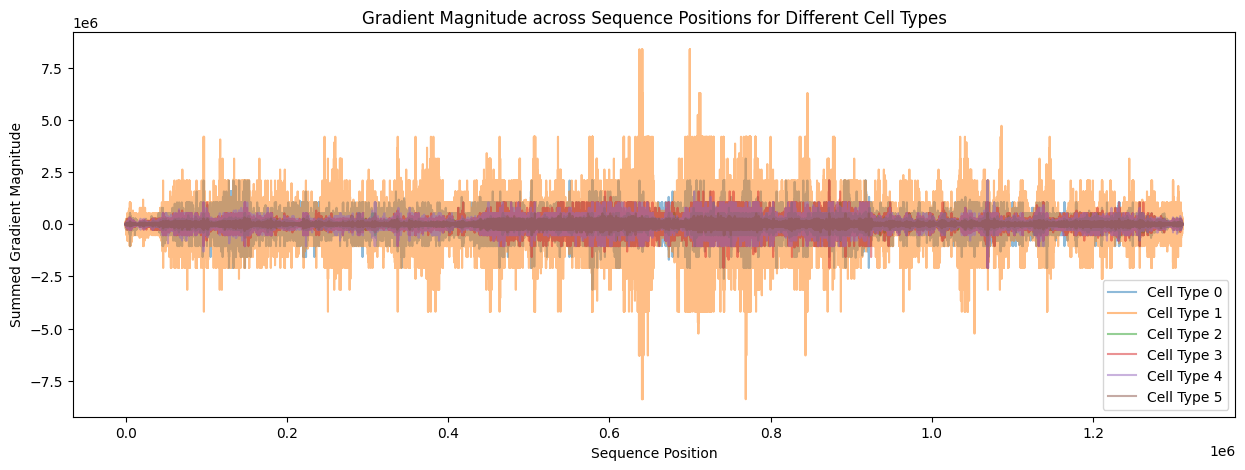

In [14]:
grads_0 = gradients_tg0.numpy().squeeze()
grads_1 = gradients_tg1.numpy().squeeze()
grads_2 = gradients_tg2.numpy().squeeze()
grads_3 = gradients_tg3.numpy().squeeze()
grads_4 = gradients_tg4.numpy().squeeze()
grads_5 = gradients_tg5.numpy().squeeze()

# Sum gradients across the one-hot encoding axis (4) to get a single value per position
summed_grads_0 = grads_0.sum(axis=-1)
summed_grads_1 = grads_1.sum(axis=-1)
summed_grads_2 = grads_2.sum(axis=-1)
summed_grads_3 = grads_3.sum(axis=-1)
summed_grads_4 = grads_4.sum(axis=-1)
summed_grads_5 = grads_5.sum(axis=-1)

# Create a sequence position axis
positions = range(summed_grads_0.shape[0])

# Plot each cell type gradient
plt.figure(figsize=(15, 5))
plt.plot(positions, summed_grads_0, label='Cell Type 0', alpha=0.5)
plt.plot(positions, summed_grads_1, label='Cell Type 1', alpha=0.5)
plt.plot(positions, summed_grads_2, label='Cell Type 2', alpha=0.5)
plt.plot(positions, summed_grads_3, label='Cell Type 3', alpha=0.5)
plt.plot(positions, summed_grads_4, label='Cell Type 4', alpha=0.5)
plt.plot(positions, summed_grads_5, label='Cell Type 5', alpha=0.5)

plt.xlabel('Sequence Position')
plt.ylabel('Summed Gradient Magnitude')
plt.title('Gradient Magnitude across Sequence Positions for Different Cell Types')
plt.legend()
plt.show()

In [15]:
def smooth_gradients(gradients, window_size=2048):
    # Ensure gradients are a numpy array
    gradients = gradients.squeeze()  # Remove extra dimensions, now shape should be (1310720, 4)

    # Check the shape after squeezing
    print("Gradient shape after squeeze:", gradients.shape)
    
    # Ensure we have the expected shape (1310720, 4)
    if len(gradients.shape) != 2:
        raise ValueError("Expected gradients to have shape (1310720, 4)")

    # Sum the gradients over the nucleotide axis to get one value per position
    summed_gradients = gradients.sum(axis=-1)  # Shape will now be (1310720,)
    
    # Apply moving average smoothing
    smoothed_gradients = np.convolve(summed_gradients, 
                                     np.ones(window_size) / window_size, mode='same')
    return smoothed_gradients

In [ ]:
# smoothed_grads_0 = smooth_gradients(averaged_gradients_tg0.numpy())
# smoothed_grads_1 = smooth_gradients(averaged_gradients_tg1.numpy())
# smoothed_grads_2 = smooth_gradients(averaged_gradients_tg2.numpy())
# smoothed_grads_3 = smooth_gradients(averaged_gradients_tg3.numpy())
# smoothed_grads_4 = smooth_gradients(averaged_gradients_tg4.numpy())
# smoothed_grads_5 = smooth_gradients(averaged_gradients_tg5.numpy())

In [17]:
smoothed_grads_0 = smooth_gradients(gradients_tg0.numpy())
smoothed_grads_1 = smooth_gradients(gradients_tg1.numpy())
smoothed_grads_2 = smooth_gradients(gradients_tg2.numpy())
smoothed_grads_3 = smooth_gradients(gradients_tg3.numpy())
smoothed_grads_4 = smooth_gradients(gradients_tg4.numpy())
smoothed_grads_5 = smooth_gradients(gradients_tg5.numpy())

Gradient shape after squeeze: (1310720, 4)
Gradient shape after squeeze: (1310720, 4)
Gradient shape after squeeze: (1310720, 4)
Gradient shape after squeeze: (1310720, 4)
Gradient shape after squeeze: (1310720, 4)
Gradient shape after squeeze: (1310720, 4)


In [23]:
def plot_smoothed_gradients(smoothed_grads):
    # Calculate overall min and max for y-axis limits
    all_gradients = np.concatenate(smoothed_grads)  # Combine all gradients for y-limits
    y_min = np.min(all_gradients)
    y_max = np.max(all_gradients)

    # Loop through each smoothed gradient to create separate plots
    for idx, smoothed_grad in enumerate(smoothed_grads):
        plt.figure(figsize=(15, 5))
        plt.plot(smoothed_grad, label=f'Cell Type {idx}', alpha=0.7)
        
        plt.xlabel("Window Number")
        plt.ylabel("Smoothed Gradient Magnitude")
        plt.title(f"Smoothed Gradient Patterns for Cell Type {idx}")
        plt.ylim(y_min, y_max)  # Set consistent y-axis limits
        plt.legend()
        plt.grid(True)
        plt.show()

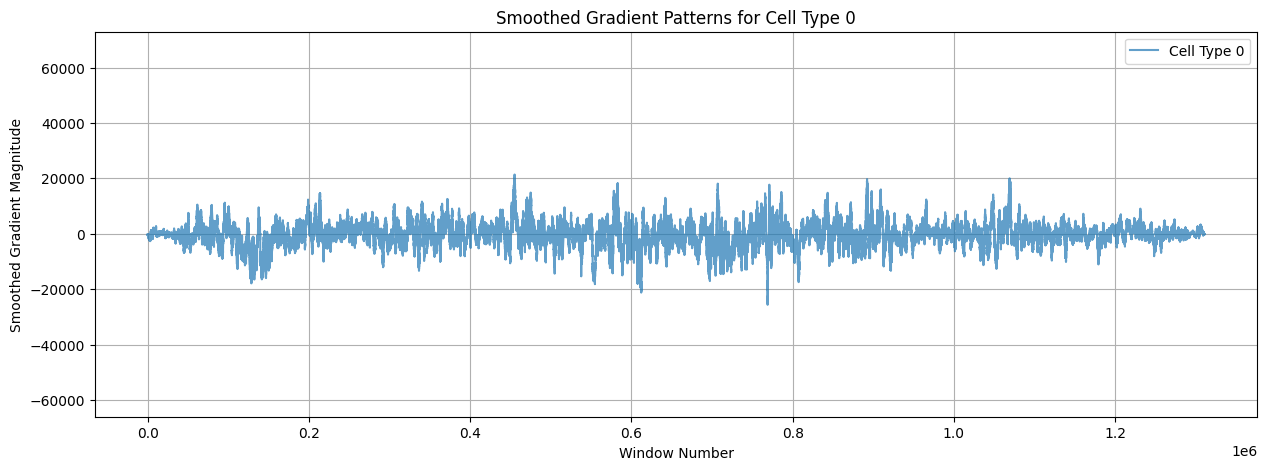

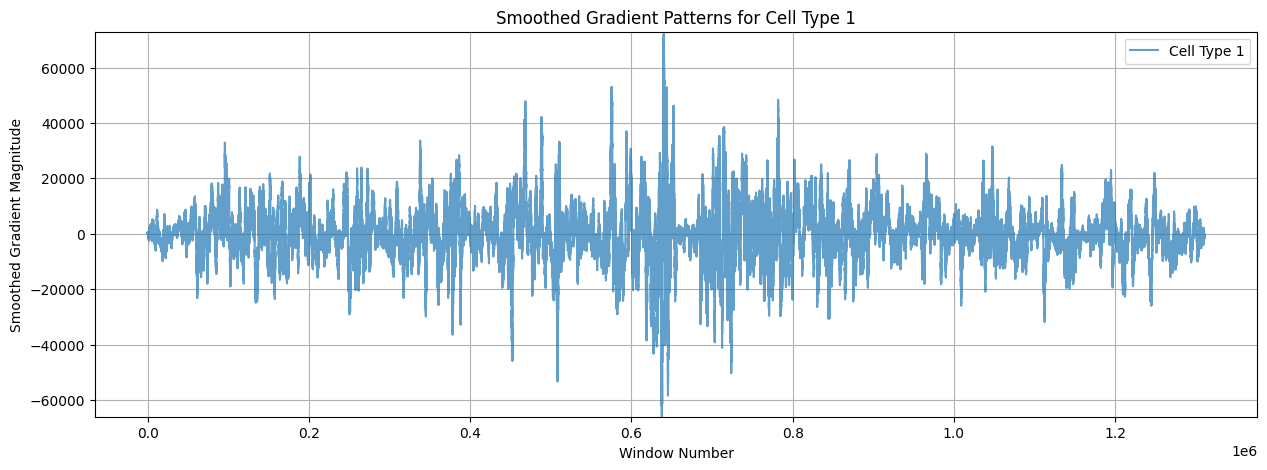

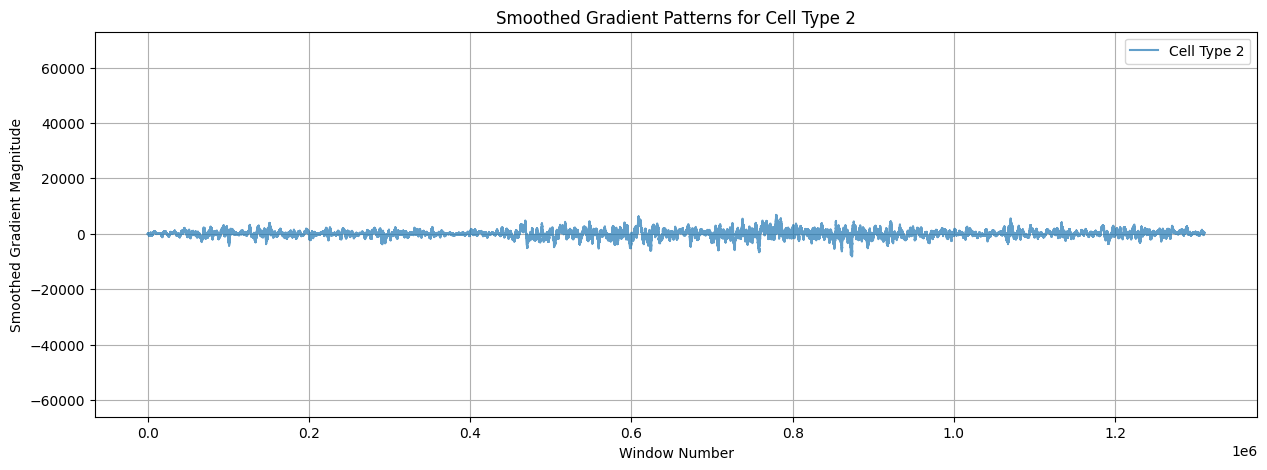

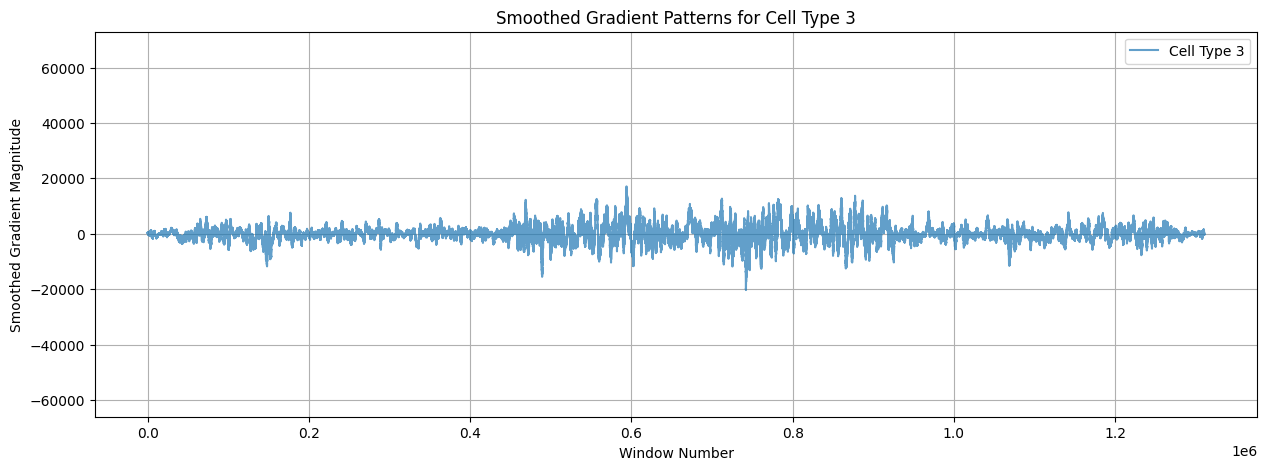

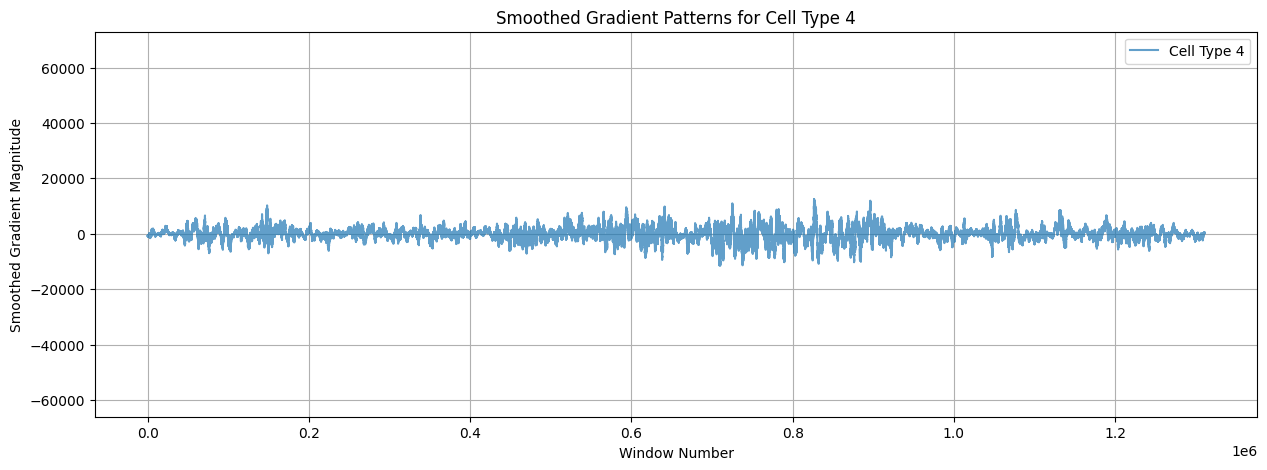

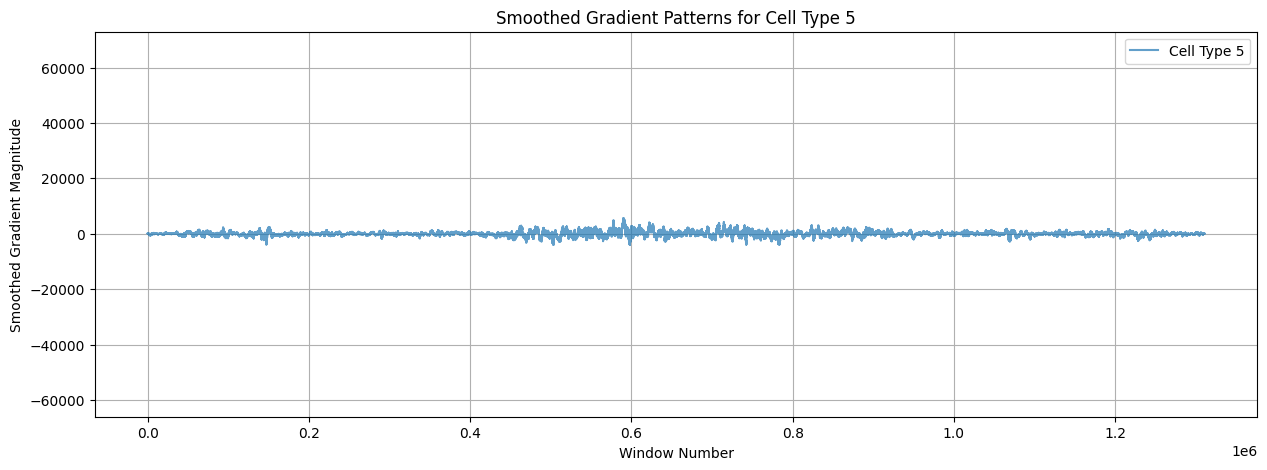

In [24]:
plot_smoothed_gradients([smoothed_grads_0, smoothed_grads_1, smoothed_grads_2,
                        smoothed_grads_3, smoothed_grads_4, smoothed_grads_5])

In [ ]:
def average_over_windows(gradients, window_size):
    # Ensure gradients are in shape [1, 1310720, 4]
    shape = gradients.shape
    assert shape[0] == 1  # Only one sample
    num_positions = shape[1]
    
    # Calculate number of windows
    num_windows = num_positions // window_size
    
    # Reshape gradients to [num_windows, window_size, 4]
    reshaped_gradients = gradients[:, :num_windows * window_size, :].reshape(1, num_windows, window_size, 4)

    # Average over the window size
    averaged_gradients = tf.reduce_mean(reshaped_gradients, axis=2)  # Average over the window dimension
    
    return averaged_gradients.numpy().squeeze()  # Remove the extra dimensions

In [ ]:
averaged_gradients_tg0.numpy().mean(axis=2).shape

In [ ]:
# Average the gradients over 2048 bp windows
window_size = 2048
averaged_gradients_windows = average_over_windows(averaged_gradients_tg0.numpy().mean(axis=2)[:,], window_size)

# Plot the averaged gradients
plt.figure(figsize=(15, 5))
plt.plot(averaged_gradients_windows)
plt.title("Averaged Gradients Over 2048 bp Windows")
plt.xlabel("Window Number")
plt.ylabel("Averaged Gradient Magnitude")
# plt.legend(['Cell Type 0', 'Cell Type 1', 'Cell Type 2', 'Cell Type 3', 'Cell Type 4', 'Cell Type 5'])
plt.show()

In [ ]:
def plot_pairwise_correlation_heatmap(*summed_grads):
    num_cell_types = len(summed_grads)
    correlations = np.zeros((num_cell_types, num_cell_types))
    
    # Calculate pairwise correlations for each unique pair of cell types
    for i in range(num_cell_types):
        for j in range(i, num_cell_types):
            corr = np.corrcoef(summed_grads[i], summed_grads[j])[0, 1]
            correlations[i, j] = corr
            correlations[j, i] = corr  # Mirror correlation to make symmetric matrix

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm",
                xticklabels=[f"Cell Type {i}" for i in range(num_cell_types)],
                yticklabels=[f"Cell Type {i}" for i in range(num_cell_types)])
    plt.title("Pairwise Correlation between Cell Type Gradients")
    plt.xlabel("Cell Type")
    plt.ylabel("Cell Type")
    plt.show()


In [ ]:
average_corr

In [ ]:
# fetching
seq_1hot = dna_1hot(
        genome_open.fetch(
            chrom, start, end
        ).upper()
    )
expanded_seq_1hot = np.expand_dims(seq_1hot, 0)

In [ ]:
expanded_seq_1hot.shape

In [ ]:
get_prediction_gradients(seqnn_model, expanded_seq_1hot)

In [ ]:
def calculate_input_gradients(model, input_seq, subtract_avg):
    # Ensure input_seq is a float32 tensor
    input_seq = tf.convert_to_tensor(input_seq, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(input_seq)
        preds = model(input_seq)

        print(preds.shape)
        print(preds)
        
        # Check if preds is None or has unexpected shape
        if preds is None or len(preds.shape) < 3:
            raise ValueError("Model predictions returned None or incorrect shape. Check the model input and architecture.")

        preds_squared = tf.square(preds)  # Square the predictions

In [ ]:
calculate_input_gradients(seqnn_model, expanded_seq_1hot, True)

In [ ]:
test_pred = seqnn_model.model.predict(expanded_seq_1hot)

In [ ]:
test_pred.shape

In [ ]:
test_pred_maps = ut_dense(test_pred[0,:,:])

In [ ]:
preds = [test_pred_maps[:,:,i] for i in range(6)]

In [ ]:
def plot_maps_with_labels(maps, labels, vmin=-0.6, vmax=0.6, palette="RdBu_r", width=20, height=5):
    fig, axes = plt.subplots(1, len(maps), figsize=(width, height))

    for i, (matrix, label) in enumerate(zip(maps, labels)):
        sns.heatmap(
            matrix,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            cmap=palette,
            square=True,
            xticklabels=False,
            yticklabels=False,
            ax=axes[i]
        )
        axes[i].set_title(label, fontsize=12)  # Set the label above the heatmap

    plt.tight_layout()
    plt.show()

In [ ]:
labels = ["mESC", "mESC", "cortical neuron", "neocortex cortical neuron", "neural progenitor cell", "neocortex neural progenitor cell"]

In [ ]:
plot_maps_with_labels(preds, labels)

In [ ]:
genome_open.close()

### Comparing with Targets

In [ ]:
# mouse targets
# index   identifier      file    description
# 0       Hsieh2019_mESC_uC       /home/drk/hic/data/data/coolers/mm10/Hsieh2019/mESC_mm10_4DNFILZ1CPT8.mapq_30.2048.cool HIC:mESC
# 1       Bonev2017_mESC  /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_ES_all.mm10.mapq_30.2048.cool        HIC:mESC
# 2       Bonev2017_CN    /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_CN_all.mm10.mapq_30.2048.cool        HIC:cortical neuron
# 3       Bonev2017_ncx_CN        /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_ncx_CN_all.mm10.mapq_30.2048.cool    HIC:neocortex cortical neuron
# 4       Bonev2017_NPC   /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_NPC_all.mm10.mapq_30.2048.cool       HIC:neural progenitor cell
# 5       Bonev2017_ncx_NPC       /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_ncx_NPC_all.mm10.mapq_30.2048.cool   HIC:neocortex neural progenitor cell

In [ ]:
cool_paths = {"Hsieh2019_mESC_uC_path" : "/project/fudenber_735/GEO/Hsieh2019/4DN/mESC_mm10_4DNFILZ1CPT8.mapq_30.2048.cool",
"Bonev2017_mESC_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES_all.mm10.mapq_30.2048.cool",
"Bonev2017_CN_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_CN_all.mm10.mapq_30.2048.cool",
"Bonev2017_ncx_CN_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ncx_CN_all.mm10.mapq_30.2048.cool",
"Bonev2017_NPC_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_NPC_all.mm10.mapq_30.2048.cool",
"Bonev2017_ncx_NPC_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ncx_NPC_all.mm10.mapq_30.2048.cool"}

In [ ]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import cooler
from cooltools.lib.numutils import observed_over_expected, adaptive_coarsegrain
from cooltools.lib.numutils import interpolate_bad_singletons, set_diag, interp_nan
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

In [ ]:
def get_target(cooler_path, padding, mseq_str, diagonal_offset=2):
    
    genome_hic_cool = cooler.Cooler(cooler_path)
    
    seq_hic_raw = genome_hic_cool.matrix(balance=True).fetch(mseq_str)

    seq_hic_nan = np.isnan(seq_hic_raw)
    # num_filtered_bins = np.sum(np.sum(seq_hic_nan,axis=0) == len(seq_hic_nan))

    # clip first diagonals and high values
    clipval = np.nanmedian(np.diag(seq_hic_raw, diagonal_offset))
    for i in range(-diagonal_offset+1, diagonal_offset):
        set_diag(seq_hic_raw, clipval, i)
    seq_hic_raw = np.clip(seq_hic_raw, 0, clipval)
    seq_hic_raw[seq_hic_nan] = np.nan
    
    # adaptively coarsegrain based on raw counts
    seq_hic_smoothed = adaptive_coarsegrain(
                        seq_hic_raw,
                        genome_hic_cool.matrix(balance=False).fetch(mseq_str),
                        cutoff=2, max_levels=8)
    seq_hic_nan = np.isnan(seq_hic_smoothed)
    
    # local obs/exp
    seq_hic_obsexp = observed_over_expected(seq_hic_smoothed, ~seq_hic_nan)[0]
    log_hic_obsexp = np.log(seq_hic_obsexp)

    # crop
    if padding > 0:
        log_hic_obsexp = log_hic_obsexp[padding:-padding,:]
        log_hic_obsexp = log_hic_obsexp[:,padding:-padding]

    # aplying Gaussian Kernel
    kernel = Gaussian2DKernel(x_stddev=1)
    kernel_log_hic_obsexp = convolve(log_hic_obsexp, kernel)
    
    return kernel_log_hic_obsexp

In [ ]:
seq_len_nt = 1310720
padding = (640-512) // 2

# chrom = "chr3"
# start = 33348564
# end = 33348564 + seq_len_nt

# chrom = "chr14"
# gene_start = 58083863
# gene_end = 58089096

# chrom = "chr2"
# gene_start = 79452639
# gene_end = 79456636

# chrom = "chr4"
# gene_start = 10881264
# gene_end = 10906709

# chrom = "chr1"
# gene_start = 66321719
# gene_end = 66439188

# chrom = "chr1"
# start = 57299397
# end = 57299397 + seq_len_nt

# chrom = "chr7"
# start = 71039589
# end = 71039589 + seq_len_nt

# gene_length = gene_end - gene_start

# if gene_length % 2 == 1:
#     gene_start = gene_start - 1

# if gene_length < seq_len_nt:
#     difference = (seq_len_nt - (gene_end - gene_start))
#     start = gene_start - (difference // 2)
# else:
#     start = gene_start
    
# end = start + seq_len_nt

In [ ]:
mseq_str = '%s:%d-%d' % (chrom, start, end)

In [ ]:
mseq_str

In [ ]:
targets = []

for path in cool_paths:
    targets.append(get_target(cool_paths[path], padding, mseq_str))

In [ ]:
def average_pooling(mat, pool_size=2):
    """
    Reduces the size of an 1153x1153 matrix to 513x513 using average pooling.
    Handles matrices that are not perfectly divisible by 2.
    """
    # Crop the matrix to 1152x1152 (since 1153 is not divisible by 2)
    mat_cropped = mat[:1152, :1152]

    # Apply average pooling manually by taking the average over 2x2 blocks
    pooled_mat = np.zeros((513, 513))
    for i in range(513):
        for j in range(513):
            pooled_mat[i, j] = np.mean(mat_cropped[i*2:i*2+2, j*2:j*2+2])
    
    return pooled_mat

In [ ]:
targets[4] = average_pooling(targets[4])

In [ ]:
for i in range(6):
    targets[i] = np.nan_to_num(targets[i], nan=0)

In [ ]:
plot_maps_with_labels(targets, labels)

In [ ]:
from scipy.stats import pearsonr, ttest_rel

In [ ]:
# for i in range(6):
#     print(np.isnan(preds[i]).any())

In [ ]:
# for i in range(6):
#     print(np.isnan(targets[i]).any())

In [ ]:
def trim_matrix(mat):
    return mat[:-1, :-1] 

def correlation_matrix(mat1, mat2):
    """Calculate Pearson correlation between two 512x512 matrices."""
    mat1_flat = mat1.flatten()
    mat2_flat = mat2.flatten()
    return pearsonr(mat1_flat, mat2_flat)[0]  # Pearson correlation coefficient

def get_correlations(preds, targets):
    num_cell_types = len(targets)
    
    # Lists to store correlations
    target_vs_target_corr = []
    pred_vs_target_corr = []
    
    for i in range(num_cell_types):
        for j in range(num_cell_types):
            # Trim the target matrices (513x513 -> 512x512)
            target_i_trimmed = trim_matrix(targets[i])
            target_j_trimmed = trim_matrix(targets[j])
            
            # Trim predicted matrix (if needed)
            pred_i = preds[i]  # Assuming preds are already 512x512

            # Calculate target vs target correlations
            target_corr = correlation_matrix(target_i_trimmed, target_j_trimmed)
            target_vs_target_corr.append((i, j, target_corr))  # (cell_type1, cell_type2, correlation)

            # Calculate predicted vs target correlations
            pred_corr = correlation_matrix(pred_i, target_j_trimmed)
            pred_vs_target_corr.append((i, j, pred_corr))  # (cell_type1, cell_type2, correlation)
    
    return target_vs_target_corr, pred_vs_target_corr

def paired_t_test(target_vs_target_corr, pred_vs_target_corr):
    """
    Perform paired t-test to compare target vs target correlations
    with pred vs target correlations.
    """
    specific_corr_diff = []  # List of differences between specific correlations
    nonspecific_corr_diff = []  # List of differences between non-specific correlations

    for (i1, j1, target_corr), (i2, j2, pred_corr) in zip(target_vs_target_corr, pred_vs_target_corr):
        assert i1 == i2 and j1 == j2  # Ensure we are comparing the same pairs

        if i1 == j1:  # Within-cell type (specific)
            specific_corr_diff.append(pred_corr - target_corr)
        else:  # Cross-cell type (non-specific)
            nonspecific_corr_diff.append(pred_corr - target_corr)

    # Perform paired t-test
    specific_stat, specific_p = ttest_rel([x for x in specific_corr_diff], [0]*len(specific_corr_diff))
    nonspecific_stat, nonspecific_p = ttest_rel([x for x in nonspecific_corr_diff], [0]*len(nonspecific_corr_diff))
    
    return specific_stat, specific_p, nonspecific_stat, nonspecific_p

In [ ]:
target_vs_target_corr, pred_vs_target_corr = get_correlations(preds, targets)
# target_vs_target_corr -> This is a list that stores the correlations between target matrices.
# pred_vs_target_corr -> This is a list that stores the correlations between predicted matrices and target matrices.

In [ ]:
specific_stat, specific_p, nonspecific_stat, nonspecific_p = paired_t_test(target_vs_target_corr, pred_vs_target_corr)

In [ ]:
print(f"Specific correlations t-statistic: {specific_stat}, p-value: {specific_p}")

In [ ]:
# The t-statistic is negative, indicating that the predicted correlations tend to be lower than the target correlations within the same cell type.
# The model’s predictions for within-cell-type (specific) correlations are statistically significantly lower than the target correlations. 
# This suggests that the model may struggle to fully capture the precise contact frequency patterns specific to each cell type.

In [ ]:
print(f"Non-specific correlations t-statistic: {nonspecific_stat}, p-value: {nonspecific_p}")

In [ ]:
# The positive t-statistic indicates that the predicted correlations tend to be higher than the target correlations across different cell types.
# The model’s predictions for non-specific (cross-cell-type) correlations are statistically significantly higher than the actual 
# (target) cross-cell-type correlations. This suggests that the model may be predicting more similarity between different cell types than what 
# is present in the target data, implying a lack of cell-type specificity in its predictions.